In [2]:

import zipfile
import os
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import xml.etree.ElementTree as ET
import tensorflow as t
import torch
from sentence_transformers import SentenceTransformer, util

2024-07-17 20:31:54.900475: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-17 20:31:54.965815: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-17 20:31:55.109837: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-17 20:32:03.503528: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/claney/anaconda3/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebo

# Unzipping csv file

In [3]:

uploaded_zip = '/home/claney/EclipsePlatform/eclipse_platform.zip'
extract_dir = '/home/claney/extracted'
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)
with zipfile.ZipFile(uploaded_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

csv_file = os.path.join(extract_dir, 'eclipse_platform.csv')
full_df = pd.read_csv(csv_file)

In [4]:
full_df.fillna(0,inplace=True)

# Spliting testing and training

In [5]:
df_sorted = full_df.sort_values(by='Created_time')


In [6]:
length=len(df_sorted)
split_index=int(.8*length)
df=df_sorted.iloc[:split_index] #df=training set


In [7]:
df.head()

,Issue_id,Priority,Component,Duplicated_issue,Title,Description,Status,Resolution,Version,Created_time,Resolved_time
0,1,P3,Team,0.0,Usability issue with external editors (1GE6IRL),- Setup a project that contains a *.gif resour...,CLOSED,FIXED,2.0,2001-10-10 21:34:00 -0400,2012-02-09 15:57:47 -0500
12,13,P3,Team,0.0,CC Discussion: local versioning (1GAT3PL),Would it make sense to have a (the?) projects ...,VERIFIED,FIXED,2.0,2001-10-10 21:34:00 -0400,2001-10-29 16:51:09 -0500
11,12,P3,Team,0.0,Manage/unmanage support and policies (1GALAEG),Currently every new resource added to a shared...,RESOLVED,WONTFIX,2.0,2001-10-10 21:34:00 -0400,2001-10-23 23:39:24 -0400
10,11,P3,Team,0.0,API: ISharingManager::load mapping vcm project...,Jean-Michel (08/02/2001 1:38:48 PM); ; The ISh...,RESOLVED,WONTFIX,2.0,2001-10-10 21:34:00 -0400,2001-10-23 23:39:22 -0400
9,10,P3,Team,0.0,API - VCM event notification (1G8G6RR),There seems to be a need for a VCM Event notif...,VERIFIED,FIXED,2.0,2001-10-10 21:34:00 -0400,2008-10-10 18:47:42 -0400


In [21]:
type(df['Duplicated_issue'])

pandas.core.series.Series

# Creating isDuplicate column

In [8]:
def is_duplicate(val):
    return 1 if val !=0.0 else 0
df['isDuplicate'] = df['Duplicated_issue'].apply(lambda x: is_duplicate(x))

print(df['isDuplicate'])

0        0
12       0
11       0
10       0
9        0
        ..
68119    0
68120    0
68121    0
68122    0
68123    0
Name: isDuplicate, Length: 68124, dtype: int64


/tmp/ipykernel_225386/1537637410.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['isDuplicate'] = df['Duplicated_issue'].apply(lambda x: is_duplicate(x))


isDuplicate
0    56126
1    11998
Name: count, dtype: int64


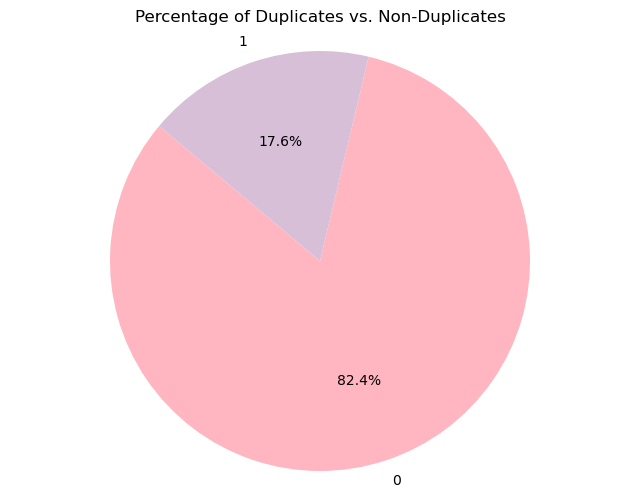

In [9]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and 'isDuplicate' is the column indicating duplicates
duplicate_counts = df['isDuplicate'].value_counts()

# Check the contents of duplicate_counts
print(duplicate_counts)

# Create a list of labels matching the length of duplicate_counts
# Ensure the labels match the values in the 'isDuplicate' column
labels = duplicate_counts.index.tolist()

# Define colors (length should match number of unique values in 'isDuplicate')
colors = ['#FFB6C1', '#D8BFD8'][:len(labels)]

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(duplicate_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Percentage of Duplicates vs. Non-Duplicates')
plt.axis('equal')
plt.show()


# Preprocessing

In [10]:
df['Description'] = df['Description'].astype(str).fillna('')

/tmp/ipykernel_225386/77102330.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Description'] = df['Description'].astype(str).fillna('')


In [11]:
#creating freeform textual data column
df['full_text_data']=df['Description']+df['Title']
print(df['full_text_data'])
df['full_text_data']=df['full_text_data'].fillna('')

0        - Setup a project that contains a *.gif resour...
12       Would it make sense to have a (the?) projects ...
11       Currently every new resource added to a shared...
10       Jean-Michel (08/02/2001 1:38:48 PM); ; The ISh...
9        There seems to be a need for a VCM Event notif...
                               ...                        
68119    Build ID: 3.3 (I am not sure what You mean by ...
68120    There are several NPEs within the UI session t...
68121    I20080501-0100; ; Now that were using the coll...
68122    Created attachment 98318; screenshot; ; I20080...
68123    Build ID: M20080221-1800; ; Steps To Reproduce...
Name: full_text_data, Length: 68124, dtype: object


/tmp/ipykernel_225386/3345744263.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['full_text_data']=df['Description']+df['Title']
/tmp/ipykernel_225386/3345744263.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['full_text_data']=df['full_text_data'].fillna('')


# Creating topics using LDA

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer
count_vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')

# Fit and transform the CountVectorizer on the text data
counts = count_vectorizer.fit_transform(df['full_text_data'])

count_vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')
counts = count_vectorizer.fit_transform(df['full_text_data'])

        # Fit LDA model
lda = LatentDirichletAllocation(n_components=7, max_iter=10,learning_method='online',learning_offset=50.,random_state=0)
lda.fit(counts)


LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          n_components=7, random_state=0)

In [13]:
feature_names = count_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-20 - 1:-1]]))
        
        print()

Topic 1:
swt display widgets shell eclipse org new control ljava composite os junit framework dylib import widget lorg windowproc win32 event

Topic 2:
eclipse org osgi core framework update plugins message com ui help jar bundle platform xml equinox ant http apache plugin

Topic 3:
line editor view new open public menu text window int button item does string null click object perspective tab selection

Topic 4:
eclipse lib 03 00000000 usr dll 00 object org jar xp system32 java lang windows plugins rwxp jre 08 02

Topic 5:
java org eclipse internal ui core run swt main workbench widgets jface runtime lang method display reflect launcher widget invoke

Topic 6:
text search table image gtk styledtext linux font column color string width icons background characters abstractdocument index windows size markers

Topic 7:
file project eclipse build cvs dialog error view new workspace files use using does problem bug user create like set



In [14]:
#for alll columns in the df 
#compare each bug report to each topic 
#if
topic_distributions = lda.transform(counts)

In [15]:
df['topic'] = topic_distributions.argmax(axis=1)

# Create DataFrames for each topic
topic_dfs = []
for topic_idx in range(7):
    topic_df = df[df['topic'] == topic_idx].copy()
    topic_dfs.append(topic_df)

# Display the DataFrames for each topic
for i, topic_df in enumerate(topic_dfs):
    print(f"Topic {i}:")
    print(topic_df['full_text_data'])
    print()

#save each DataFrame to a CSV file
for i, topic_df in enumerate(topic_dfs):
    topic_df.to_csv(f'topic_{i}_bug_reports.csv', index=False)

/tmp/ipykernel_225386/3871166757.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['topic'] = topic_distributions.argmax(axis=1)


Topic 0:
216      While minimizing an Eclipse running in Eclipse...
330      DW (12/8/00 4:03:27 PM); \tThe old VAME debugg...
416      Debugger Stack Trace Report:; ; Thread[main;5;...
1202     Create a TextViewer; give it a string for its ...
1308     Self hosting Eclipse; my target workbench cras...
                               ...                        
67999    using org.eclipse.swt_3.4.0.v3436a.jar and org...
68000    using org.eclipse.swt_3.4.0.v3436a.jar and org...
68040    Here is the follow up got Bug 227968. The prob...
68105    - run the snippet below; - note that the main ...
68118    swt.jar from the I20080429-0100 build; setRegi...
Name: full_text_data, Length: 1504, dtype: object

Topic 1:
245      I created a new stream in the repository; made...
221      prefix        test; name          181178; refe...
295      |     To:  Brian Young/OTT/OTI@OTI; Dave Thoms...
319      MF (6/5/01 12:10:21 PM); \t\twe silently ignor...
321      Please respond to Susan Griffin/OTT/O

In [16]:
topic_0_df=pd.read_csv('topic_0_bug_reports.csv')
topic_1_df=pd.read_csv('topic_1_bug_reports.csv')
topic_2_df=pd.read_csv('topic_2_bug_reports.csv')
topic_3_df=pd.read_csv('topic_3_bug_reports.csv')
topic_4_df=pd.read_csv('topic_4_bug_reports.csv')
topic_5_df=pd.read_csv('topic_5_bug_reports.csv')
topic_6_df=pd.read_csv('topic_6_bug_reports.csv')


#storaging them in seperate csv so when we do classifciaton on them its alll seperate 

# Cosine similarity top-K

In [67]:
import torch
from sentence_transformers import SentenceTransformer, util
import pandas as pd

def get_top_k_similar_v3(df, k, model_name='paraphrase-MiniLM-L6-v2'):
    # Load the model
    model = SentenceTransformer(model_name)
    
    # Encode sentences and store the embeddings in the DataFrame
    df['embeddings'] = df['full_text_data'].apply(lambda x: model.encode(x, convert_to_tensor=True))
    
    # Convert embeddings to a tensor
    embeddings = torch.stack(df['embeddings'].tolist())
    
    # Calculate cosine similarity
    cosine_scores = util.pytorch_cos_sim(embeddings, embeddings)
    
    # Store the top k similar pairs
    top_k_similarities = {}
    for i in range(len(cosine_scores)):
        similarities = [(j, cosine_scores[i][j].item()) for j in range(len(cosine_scores)) if i != j]
        top_k_similarities[i] = sorted(similarities, key=lambda x: x[1], reverse=True)[:k]
    
    # Create a new column to store the experimental duplicate Issue IDs
    def get_experimental_duplicates(idx):
        similar_pairs = top_k_similarities[idx]
        if all(score < 0.9 for _, score in similar_pairs):
            return [0]
        else:
            return [df.loc[pair[0], 'Issue_id'] for pair in similar_pairs]
    
    df['Experimental_Duplicate_IDs'] = df.index.map(get_experimental_duplicates)
    
    return df


In [63]:
print(get_top_k_similar_v3(test_df_1,10))

      Issue_id Priority Component  Duplicated_issue  \
0          217       P3      Team               0.0   
1         1533       P2     Debug               0.0   
2         1850       P3        UI               0.0   
3         2650       P3        UI               0.0   
4         2760       P3        UI               0.0   
...        ...      ...       ...               ...   
1499    228762       P3       SWT               0.0   
1500    228770       P3       SWT               0.0   
1501    229172       P3       SWT               0.0   
1502    229680       P3       SWT               0.0   
1503    229776       P3       SWT               0.0   

                                                  Title  \
0                          UI BUG TO BE FILED (1GHQOGF)   
1     Feature: notification of changing variables (1...   
2                    WALKBACK - EditableTable (1G5T6MC)   
3     [JFace Text] TextViewer#setVisibleRegion doesn...   
4     Workbench resizing crash (stack overfl

In [34]:
test_df_1=topic_0_df.copy()
test_df_1.head()

,Issue_id,Priority,Component,Duplicated_issue,Title,Description,Status,Resolution,Version,Created_time,Resolved_time,isDuplicate,full_text_data,topic
0,217,P3,Team,0.0,UI BUG TO BE FILED (1GHQOGF),While minimizing an Eclipse running in Eclipse...,RESOLVED,INVALID,2.0,2001-10-10 21:38:00 -0400,2001-10-23 23:47:22 -0400,0,While minimizing an Eclipse running in Eclipse...,0
1,1533,P2,Debug,0.0,Feature: notification of changing variables (1...,DW (12/8/00 4:03:27 PM); \tThe old VAME debugg...,VERIFIED,FIXED,2.0,2001-10-10 22:14:00 -0400,2002-02-04 13:16:45 -0500,0,DW (12/8/00 4:03:27 PM); \tThe old VAME debugg...,0
2,1850,P3,UI,0.0,WALKBACK - EditableTable (1G5T6MC),Debugger Stack Trace Report:; ; Thread[main;5;...,RESOLVED,FIXED,2.0,2001-10-10 22:20:00 -0400,2001-11-13 15:30:56 -0500,0,Debugger Stack Trace Report:; ; Thread[main;5;...,0
3,2650,P3,UI,0.0,[JFace Text] TextViewer#setVisibleRegion doesn...,Create a TextViewer; give it a string for its ...,RESOLVED,WONTFIX,2.0,2001-10-10 22:40:00 -0400,2009-08-30 02:31:49 -0400,0,Create a TextViewer; give it a string for its ...,0
4,2760,P3,UI,0.0,Workbench resizing crash (stack overflow) (1GI...,Self hosting Eclipse; my target workbench cras...,RESOLVED,INVALID,2.0,2001-10-10 22:43:00 -0400,2002-01-08 15:59:57 -0500,0,Self hosting Eclipse; my target workbench cras...,0


In [32]:
get_top_k_similar(test_df,5)

/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


,Issue_id,Priority,Component,Duplicated_issue,Title,Description,Status,Resolution,Version,Created_time,Resolved_time,isDuplicate,full_text_data,topic,embeddings,Experimental_Duplicate_IDs
0,217,P3,Team,0.0,UI BUG TO BE FILED (1GHQOGF),While minimizing an Eclipse running in Eclipse...,RESOLVED,INVALID,2.0,2001-10-10 21:38:00 -0400,2001-10-23 23:47:22 -0400,0,While minimizing an Eclipse running in Eclipse...,0,"[tensor(-0.1557), tensor(-0.0240), tensor(0.05...","[4777, 15283, 27369, 2760, 4706]"
1,1533,P2,Debug,0.0,Feature: notification of changing variables (1...,DW (12/8/00 4:03:27 PM); \tThe old VAME debugg...,VERIFIED,FIXED,2.0,2001-10-10 22:14:00 -0400,2002-02-04 13:16:45 -0500,0,DW (12/8/00 4:03:27 PM); \tThe old VAME debugg...,0,"[tensor(-0.1963), tensor(0.2270), tensor(-0.05...","[112791, 197508, 131160, 27305, 111846]"
2,1850,P3,UI,0.0,WALKBACK - EditableTable (1G5T6MC),Debugger Stack Trace Report:; ; Thread[main;5;...,RESOLVED,FIXED,2.0,2001-10-10 22:20:00 -0400,2001-11-13 15:30:56 -0500,0,Debugger Stack Trace Report:; ; Thread[main;5;...,0,"[tensor(-0.4983), tensor(-0.2631), tensor(0.03...","[15466, 137714, 20279, 73817, 34330]"
3,2650,P3,UI,0.0,[JFace Text] TextViewer#setVisibleRegion doesn...,Create a TextViewer; give it a string for its ...,RESOLVED,WONTFIX,2.0,2001-10-10 22:40:00 -0400,2009-08-30 02:31:49 -0400,0,Create a TextViewer; give it a string for its ...,0,"[tensor(-0.0025), tensor(0.0376), tensor(-0.17...","[87238, 95750, 202524, 205713, 87460]"
4,2760,P3,UI,0.0,Workbench resizing crash (stack overflow) (1GI...,Self hosting Eclipse; my target workbench cras...,RESOLVED,INVALID,2.0,2001-10-10 22:43:00 -0400,2002-01-08 15:59:57 -0500,0,Self hosting Eclipse; my target workbench cras...,0,"[tensor(0.1617), tensor(-0.0578), tensor(0.014...","[217, 4777, 15283, 49778, 49779]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1499,228762,P3,SWT,0.0,setRegion on Button behaving strangely after s...,using org.eclipse.swt_3.4.0.v3436a.jar and org...,RESOLVED,FIXED,3.4,2008-04-24 16:51:00 -0400,2008-05-16 11:50:35 -0400,0,using org.eclipse.swt_3.4.0.v3436a.jar and org...,0,"[tensor(0.1469), tensor(-0.0787), tensor(-0.16...","[228770, 98439, 229776, 83893, 217137]"
1500,228770,P3,SWT,0.0,setRegion on Canvas not working on linux,using org.eclipse.swt_3.4.0.v3436a.jar and org...,RESOLVED,FIXED,3.4,2008-04-24 17:20:00 -0400,2008-04-25 11:54:57 -0400,0,using org.eclipse.swt_3.4.0.v3436a.jar and org...,0,"[tensor(0.1452), tensor(-0.0586), tensor(-0.27...","[228762, 98439, 229776, 97394, 13020]"
1501,229172,P3,SWT,0.0,[Win32] MessageBox gets stuck in event loop,Here is the follow up got Bug 227968. The prob...,RESOLVED,FIXED,3.4,2008-04-28 16:38:00 -0400,2008-05-15 11:10:54 -0400,0,Here is the follow up got Bug 227968. The prob...,0,"[tensor(-0.2381), tensor(0.0721), tensor(-0.04...","[79934, 51252, 129999, 101093, 94202]"
1502,229680,P3,SWT,0.0,PRIMARY_MODAL Shell can make other Shell lose ...,- run the snippet below; - note that the main ...,RESOLVED,FIXED,3.4,2008-04-30 13:24:00 -0400,2008-05-15 11:10:20 -0400,0,- run the snippet below; - note that the main ...,0,"[tensor(-0.0261), tensor(0.2412), tensor(0.029...","[90732, 130878, 97915, 218562, 96342]"


In [20]:
get_top_k_similar(test_df,5)
print(test_df)

/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

KeyboardInterrupt



In [73]:
def recallRateAtK(df,k):
    #updates the row called Experimental_Duplicate_IDs to have the top k most similar bug ids
    top_k_recommendations_df=get_top_k_similar_v3(df,k)
    matches=find_num_matches(top_k_recommendations_df) #finds relevant results 
    total=top_k_recommendations_df.shape[0]# Get the number of rows
    recallRateAtk=matches/total
    
    return recallRateAtk

In [29]:

import pandas as pd

def count_matches(row):
    return sum(1 for element in row['Experimental_Duplicate_IDs'] if element == row['Duplicated_issue'])

def find_num_matches(df):
    return df.apply(count_matches, axis=1).sum()

matches = find_num_matches(test_df)
print(f'Number of matches: {matches}')



Number of matches: 22


In [44]:
print(recallRateAtK(5,test_df_1)*100)

83.57712765957447


In [75]:

topic_0_vals=[]
recall_at_5_0=recallRateAtK(topic_0_df,5)
recall_at_10_0=recallRateAtK(topic_0_df,10)
recall_at_15_0=recallRateAtK(topic_0_df,15)
recall_at_20_0=recallRateAtK(topic_0_df,20)
topic_0_vals.append(recall_at_5_0)
topic_0_vals.append(recall_at_10_0)
topic_0_vals.append(recall_at_15_0)
topic_0_vals.append(recall_at_20_0)
print("Recall for topic 0 at 5 is "+ str(recall_at_5_0))
print("Recall for topic 0 at 5 is "+ str(recall_at_10_0))
print("Recall for topic 0 at 5 is "+ str(recall_at_15_0))
print("Recall for topic 0 at 5 is "+ str(recall_at_20_0))


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


0.8357712765957447


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


0.8357712765957447


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


0.836436170212766


In [76]:
# Initialize an empty list to store recall values for each topic
all_topic_vals = []

# Loop over topics 0 to 6
for topic_num in range(7):
    topic_vals = []
    topic_df = globals()[f'topic_{topic_num}_df']  # Dynamically get the DataFrame for the current topic

    # Calculate recall values at different k-values
    recall_at_5 = recallRateAtK(topic_df, 5)
    recall_at_10 = recallRateAtK(topic_df, 10)
    recall_at_15 = recallRateAtK(topic_df, 15)
    recall_at_20 = recallRateAtK(topic_df, 20)

    # Append recall values to the list for the current topic
    topic_vals.append(recall_at_5)
    topic_vals.append(recall_at_10)
    topic_vals.append(recall_at_15)
    topic_vals.append(recall_at_20)

    # Print recall values for the current topic
    print(f"Recall for topic {topic_num} at 5 is " + str(recall_at_5))
    print(f"Recall for topic {topic_num} at 10 is " + str(recall_at_10))
    print(f"Recall for topic {topic_num} at 15 is " + str(recall_at_15))
    print(f"Recall for topic {topic_num} at 20 is " + str(recall_at_20))

    # Append the recall values for the current topic to the overall list
    all_topic_vals.append(topic_vals)

# Now all_topic_vals contains recall values for all topics 0-6


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resum

Recall for topic 0 at 5 is 0.8357712765957447
Recall for topic 0 at 10 is 0.8357712765957447
Recall for topic 0 at 15 is 0.8357712765957447
Recall for topic 0 at 20 is 0.836436170212766


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resum

Recall for topic 1 at 5 is 0.8073888091822095
Recall for topic 1 at 10 is 0.8073888091822095
Recall for topic 1 at 15 is 0.8081061692969871
Recall for topic 1 at 20 is 0.8081061692969871


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resum

Recall for topic 2 at 5 is 0.8234941400926683
Recall for topic 2 at 10 is 0.8235486508585446
Recall for topic 2 at 15 is 0.8235486508585446
Recall for topic 2 at 20 is 0.8236031616244208


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resum

Recall for topic 3 at 5 is 0.6188466947960619
Recall for topic 3 at 10 is 0.620253164556962
Recall for topic 3 at 15 is 0.620253164556962
Recall for topic 3 at 20 is 0.6216596343178622


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resum

Recall for topic 4 at 5 is 0.6510491520551883
Recall for topic 4 at 10 is 0.6523426271917218
Recall for topic 4 at 15 is 0.6529175050301811
Recall for topic 4 at 20 is 0.6533486634090255


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resum

Recall for topic 5 at 5 is 0.8226065969428801
Recall for topic 5 at 10 is 0.8226065969428801
Recall for topic 5 at 15 is 0.8226065969428801
Recall for topic 5 at 20 is 0.8226065969428801


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resum

Recall for topic 6 at 5 is 0.8282576701007586
Recall for topic 6 at 10 is 0.828342578965244
Recall for topic 6 at 15 is 0.828342578965244
Recall for topic 6 at 20 is 0.828342578965244


In [69]:
print(topic_0_df.head())
print(topic_0_df.dtypes)


   Issue_id Priority Component  Duplicated_issue  \
0       217       P3      Team               0.0   
1      1533       P2     Debug               0.0   
2      1850       P3        UI               0.0   
3      2650       P3        UI               0.0   
4      2760       P3        UI               0.0   

                                               Title  \
0                       UI BUG TO BE FILED (1GHQOGF)   
1  Feature: notification of changing variables (1...   
2                 WALKBACK - EditableTable (1G5T6MC)   
3  [JFace Text] TextViewer#setVisibleRegion doesn...   
4  Workbench resizing crash (stack overflow) (1GI...   

                                         Description    Status Resolution  \
0  While minimizing an Eclipse running in Eclipse...  RESOLVED    INVALID   
1  DW (12/8/00 4:03:27 PM); \tThe old VAME debugg...  VERIFIED      FIXED   
2  Debugger Stack Trace Report:; ; Thread[main;5;...  RESOLVED      FIXED   
3  Create a TextViewer; give it a string f

In [71]:
copy=topic_1_df.copy()
copy=get_top_k_similar_v3(copy,5)

KeyboardInterrupt: 

In [ ]:
def recall(topic_x_df):
    topic_x_df.fillna(0,inplace=True) #fills with zeros for new column 
    exp_ids = topic_x_df['Experimental_Duplicate_ID'].astype(str).str.split().apply(lambda x: [i.strip() for i in x])
    dup_ids = topic_x_df['Duplicated_issue'].astype(str).str.split().apply(lambda x: [i.strip() for i in x])
    
    # Convert all elements to strings to ensure consistent comparison
    exp_ids = exp_ids.apply(lambda x: [float(i) for i in x])
    dup_ids = dup_ids.apply(lambda x: [float(i) for i in x])
    # Check for any matches for each row
    matches = exp_ids.combine(dup_ids, lambda exp_list, dup_list: any(dup_id in exp_list for dup_id in dup_list))
    
    # Count the number of matches which is when the experiment and actual match aka true positive
    truePositive = matches.sum()

    # Convert columns to sets
    experimental_set = set(topic_x_df['Experimental_Duplicate_ID'])
    actual_set = set(topic_x_df['Duplicated_issue'])

    # Identify False Negatives
    falseNegatives = actual_set - experimental_set
    falseNegativesCount=len(list(falseNegatives))
    recall=truePositive/(truePositive+falseNegativesCount)
    return recall